# To do list
    - Nicer graph in Q2, can this be displayed differently? fuck den er grim man
    - Do a solve function in Q1? i.e. more elegant solution of Q1
    - Solve Q5
    - More text, i.e. more elaborate answers?

# Inaugural Project - Housing demand and taxation
### - *Mathilde Pilgaard, Klara Krogh Hammerum, Louise Albæk Jensen og Oluf Kelkjær*
A given household can spend cash $m$ on either housing or consumption $c$. Quality of housing, $h$, grants household utility and has the cost $p_{h}$ which is subject to progressive taxation and morgage cost as by equation (\ref{eq4}). The household aims to maximize utility such that optimal amounts of housing, $h^{*}$, and consumption, $c^{*}$, are met according to equation (\ref{eq1}).

\begin{align}
    c^{*},h^{*} & = \underset{c, h}{\operatorname{argmax}} c^{1-\phi}h^{\phi} \label{eq1}\tag{1} \\
    &s.t.\\
    \tilde{p}_{h} &= p_{h}\varepsilon \label{eq2}\tag{2} \\
    m &= \tau(p_{h},\tilde{p}_{h})+c \label{eq3}\tag{3} \\
    \tau(p_{h},\tilde{p}_{h})&=r p_{h}+\tau^{g}\tilde{p}_{h}+\tau^{p}max\{\tilde{p}_{h}-\bar{p},0\} \label{eq4}\tag{4}
\end{align}

The homes are taxed according to the public assesment being $\tilde{p}_{h}$. The assesment is politically decided according to equation (\ref{eq2}) by $\varepsilon$. Available cash for a given household is split between housing costs and consumption. $r$ denotes the carrying interest for purchasing a home, and $\tau^{g}$ denotes the base housing tax while the last element in equation (\ref{eq4}) homes valued above a certain cutoff, $\bar{p}$ are taxed at an additional rate $\tau^{p}$

# Q1
Construct a function that solves household's problem above. We let the market price of a home be equal to its quality:
$$ p_{h}=h $$
and assume that the household in question has cash-on-hand $m=0.5$. Notive that the monetary units is in millions DKK. In addition use the given parameter-values.
Knowing that the marketprice of a home is equal to its quality, we can use a scalar solver using the problems monotonicity.
$$ c = m - \tau(p_{h},\tilde{p}_{h})\Leftrightarrow $$
$$ c = m - rh-\tau^{g}h\varepsilon+\tau^{p}max\{h\varepsilon-\bar{p},0 \}   $$
meaning $c$ is implicit for a given level of $h$ through the budget constraint

In [1]:
par1 = {'m':0.5,
        'phi':0.3,
        'epsilon': 0.5,
        'r': 0.03,
        'tau_g': 0.012,
        'tau_p': 0.004,
        'p_bar': 3
}


# Creating utility function
def u_func(x, phi, **kwargs):
    h = x[0]
    c = x[1]
    return c**(1-phi)*h**phi


def expenditure(x,r,tau_g,epsilon,tau_p,p_bar, **kwargs):
    h = x[0]
    c = x[1]
    h_cost = r*h+tau_g*h*epsilon+tau_p*max(h*epsilon-p_bar,0)
    E = c+h_cost
    return E

In [2]:
# Importing relevant packages
from scipy import optimize



initial_guess = ([0.5, 20])
constraints = ({'type': 'ineq', 'fun': lambda x: par1['m']-expenditure(x,**par1)})
sol = optimize.minimize(lambda x: -u_func(x, **par1), initial_guess,
                       method = 'SLSQP',  constraints=constraints)

h=sol.x[0]
c=sol.x[1]
e=expenditure(sol.x,**par1)
u=u_func(sol.x,**par1)
emDKK = par1['m']-e
emDKK
print(f'For house quality={h:.2f} and consumption={c:.2f} with total expenditure={e:.2f}\nLeaves us with utility of {u:.2f} and excess {emDKK:.2f}mDKK')

For house quality=4.17 and consumption=0.35 with total expenditure=0.50
Leaves us with utility of 0.74 and excess -0.00mDKK


# Q2
Finding optimal choice of $c$ and $h$ given different levels of cash on hand, $m$.

In [3]:
import numpy as np
N = 1000

# Creating cash on hands and initializing storage 
m_array = np.linspace(0.4,2.5,N)
h_stars = np.empty(N)
c_stars = np.empty(N) 
u_stars = np.empty(N)

# Excluding m in a new dictionary, such that it can be varied.
for i, v in enumerate(m_array):
    constraints = ({'type': 'ineq', 'fun': lambda x: v-expenditure(x,**par1)})
    result_vector = optimize.minimize(lambda x: -u_func(x, **par1),
                                      initial_guess, method = 'SLSQP',
                                      constraints=constraints)
    
    # loading results
    h_stars[i] = result_vector.x[0]
    c_stars[i] = result_vector.x[1]
    u_stars[i] = u_func(result_vector.x,**par1)


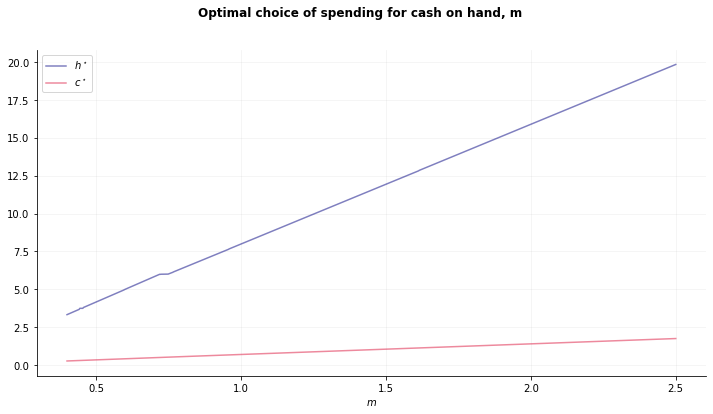

In [4]:
import matplotlib.pyplot as plt

# Create figure
fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(111)

# Plot data
ax.plot(m_array, h_stars, label=f'$h^\star$', color = 'navy', alpha = 0.5)
ax.plot(m_array, c_stars, label=f'$c^\star$', color = 'crimson', alpha = 0.5)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(f"$m$")
# Add legend (inputs are labels)
ax.legend()
# add grid
plt.grid(alpha = .15)
# add title
fig.suptitle(f'Optimal choice of spending for cash on hand, m', fontweight = 'bold')
# Show plot
plt.show()

# Q3
For parameter values as presented in Q1, the progressive housing tax will kick in at house quality, $h\cdot \varepsilon =\bar{p} \Leftrightarrow h=\frac{\bar{p}}{\varepsilon}\Leftrightarrow h=\frac{3}{0.5}=6$. Therefore a sort of clustering of $h$, just before the progressive tax kicks in, can be expected. This is evidently so, looking at the histogram of $h$.

In [5]:
import random

N = 10000
np.random.seed(1)
m_i = np.random.lognormal(-0.4,0.35, size = N)

In [6]:
def taxrev(r,phi,tau_g, epsilon, tau_p, p_bar, N, **kwargs):
    h_stars1 = np.empty(N)
    t=0
    for i, v in enumerate(m_i):
        constraints = ({'type': 'ineq', 'fun': lambda x: v-expenditure(x,r,tau_g,epsilon,tau_p,
        p_bar, **kwargs)})
        result_vector = optimize.minimize(lambda x: -u_func(x, phi),
                                      initial_guess, method = 'SLSQP',
                                      constraints=constraints)
        # loading results
        h_stars1[i] = result_vector.x[0]
        Tax = (tau_g*h_stars1[i]*epsilon+tau_p*max(h_stars1[i]*epsilon-p_bar,0))
        t += Tax
    return t/N, h_stars1



avg_tax, h_stars1 = taxrev(N=N,**par1)

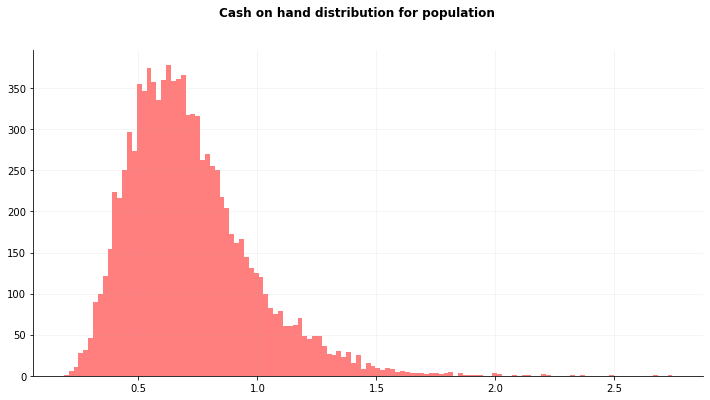

In [7]:
fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(1,1,1)

ax.hist(m_i, bins=125, alpha = 0.5, color = 'r')
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Cash on hand distribution for population', fontweight = 'bold')
plt.show()

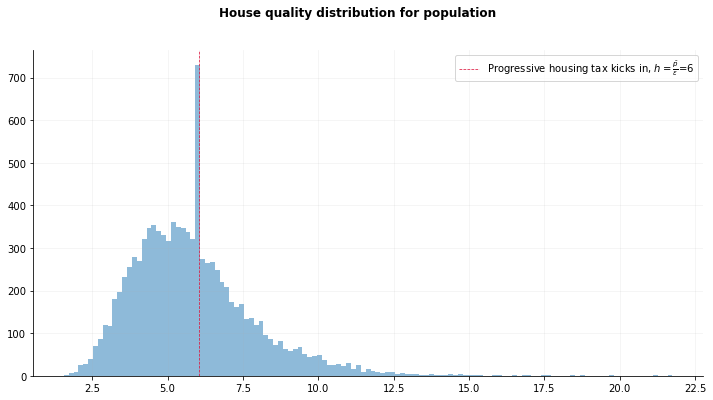

Average tax for the population is 0.036 mDKK


In [12]:
import seaborn as sns

fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(1,1,1)

ax.hist(h_stars1, bins=125, alpha = 0.5)
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(6.03, color = 'crimson', linestyle = 'dashed', linewidth = .75, label = r'Progressive housing tax kicks in, $ h = \frac{\bar{p}}{\varepsilon}$ = 6')
plt.legend()
plt.suptitle('House quality distribution for population', fontweight = 'bold')
plt.show()

print(f'Average tax for the population is {avg_tax:.3f} mDKK')
#the odd thing is the many observations around the house quality = 6

The average tax paid in the population were therefore 36.000 DKK

# Q4
Parameters for the housing tax have changed such that,
$$\epsilon = 0.8, \tau^g=0.01, \tau^p=0.009, \bar{p}=8$$
Meaning there's a lower flat housing tax and higher progressive tax with a higher triggering limit.
The triggering limit for $h$ is now, $ h\cdot\varepsilon=\bar{p}\Leftrightarrow h=\frac{\bar{p}}{\varepsilon}=\frac{8}{0.8}=10$.
The total effect of this system is now that the average tax payment has increased to 45.000 DKK as calculated below.

In [9]:
par2 = {'m':0.5,
        'phi':0.3,
        'epsilon': 0.8,
        'r': 0.03,
        'tau_g': 0.01,
        'tau_p': 0.009,
        'p_bar': 8
}

In [10]:
# Calculating and storing average tax and house quality choice for new parameters
avg_tax2, h_stars2 = taxrev(N=N,**par2)

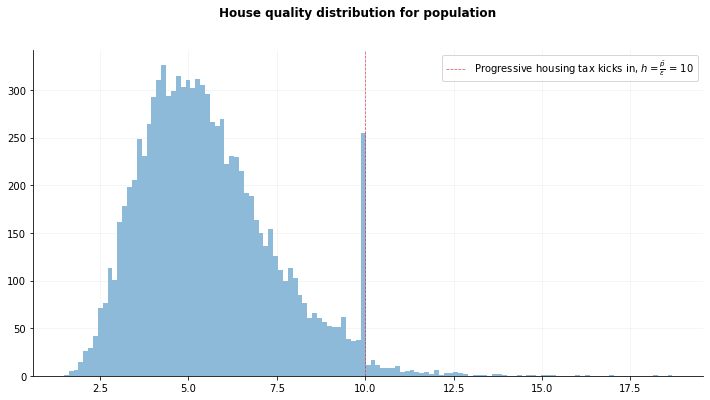

Average tax for the population is 0.045 mDKK


In [11]:
fig = plt.figure(figsize = (12,6))
# Add subplot to figure
ax = fig.add_subplot(1,1,1)

ax.hist(h_stars2, bins=125, alpha = 0.5)
ax.grid(alpha = 0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(10, color = 'crimson', linestyle = 'dashed', linewidth = .75, alpha = 0.75, label = r'Progressive housing tax kicks in, $ h = \frac{\bar{p}}{\varepsilon}$ = 10')
plt.legend()
plt.suptitle('House quality distribution for population', fontweight = 'bold')
plt.show()


print(f'Average tax for the population is {avg_tax2:.3f} mDKK')
#the odd thing is the many observations around the house quality = 10

# Q5

In [85]:
#from sympy.solvers import solve
#solve(avg_tax-taxrev(tau_g,r=0.03,phi=0.3, epsilon=0.8, tau_p=0.009, p_bar=8)[0], tau_g)


SyntaxError: unexpected EOF while parsing (<ipython-input-85-435c914770c0>, line 5)

In [77]:
taxrev(tau_g=0.01,r=0.03,phi=0.3, epsilon=0.8, tau_p=0.009, p_bar=8)[0]
constraints = ({'type': 'ineq', 'fun': lambda x: avg_tax-taxrev(x,r=0.03,phi=0.3, epsilon=0.8, tau_p=0.009, p_bar=8)[0]})
initial_guess = ([0.5, 20])
result_vector = optimize.minimize(lambda x: -u_func(x, phi=0.3),
                                  initial_guess, method = 'SLSQP',
                                  constraints=constraints)



result_vector

0.045022355268703726

In [ ]:
constraints = ({'type': 'ineq', 'fun': lambda x: avg_tax - taxrev[0]})
results = optimize.minimize(lambda x)       

def taxrev(r,phi,tau_g, epsilon, tau_p, p_bar, **kwargs):
    h_stars1 = np.empty(N)
    t=0
    for i, v in enumerate(m_i):
        constraints = ({'type': 'ineq', 'fun': lambda x: v-expenditure(x,r,tau_g,epsilon,tau_p,p_bar, **kwargs)})
        result_vector = optimize.minimize(lambda x: -u_func(x, phi),
                                      initial_guess, method = 'SLSQP',
                                      constraints=constraints)
        # loading results
        h_stars1[i] = result_vector.x[0]
        Tax = (tau_g*h_stars1[i]*epsilon+tau_p*max(h_stars1[i]*epsilon-p_bar,0))
        t += Tax
    return t/N, h_stars1



avg_tax, h_stars1 = taxrev(**par2)

In [ ]:
############################### GRAVEYARD #####################################

# def u_optimizer(phi, m, epsilon, r, tau_g, tau_p, p_bar, print_res = False, **kwargs):
#     sol = optimize.minimize_scalar(lambda h: value_of_choice(h,phi, m, epsilon, r, tau_g, tau_p, p_bar),
#                                   method = 'bounded', bounds = (0,m*10))
#     h = sol.x
#     h_cost = r*h+tau_g*h*epsilon+tau_p*max(h*epsilon-p_bar,0) 
#     c = m - h_cost
#     u = u_func(c,h,phi)
    
    
#     if print_res == True:
#         excess_dkk = m - h_cost - c
        
#         text = f'---'*35
#         text += '\nFor parameters:\n'
#         text += f'\u03C6={phi:.3f}'
#         text += f' m={m:.3f}'
#         text += f' \u03B5={epsilon:.3f}'
#         text += f' r={r:.3f}'
#         text += f' \u03C4ᵍ={tau_g:.3f}'
#         text += f' \u03C4ᵖ={tau_p:.3f}'
    
#         text += f'\nThe optimal allocation of ressources is consuming c={c:.3f} while buying a house of quality h={h:.3f} \n'
#         text += f'As the household pays no downpayment and only has to service interest-rate and housing taxes, the total spending amounts to:\n'
#         text += f'c={c:.3f} and buying a house of quality h={h:.3f} at a cost of {h_cost:.3f} leaving excess mDKK of {excess_dkk:.3f}\n\n'
#         text += f'Above allocation of ressources results in a utility of {u:.3f}\n'
#         text += f'---'*35
#         print(text)
    
#     return u, h, c

# u_star, h_star, c_star = u_optimizer(**par1, print_res = True)



# # evaluate utility function
# def u(h, c, phi, **kwargs):
#     return c**(1-phi)*h**phi


# h_grid,c_grid = np.meshgrid(h_stars,c_stars,indexing='ij')
# u_grid = u(h_grid,c_grid,**par1)

# # import plot modules - figures should be inlined
# %matplotlib inline 
# plt.style.use('seaborn-whitegrid') # whitegrid is nice for 3D
# from mpl_toolkits.mplot3d import Axes3D # for 3d figures
# from matplotlib import cm # for colormaps

# # write your code here
# # a actual plot
# fig = plt.figure(figsize= (12,6))
# ax = fig.add_subplot(1, 1, 1, projection = '3d') # note: fig.add_subplot(a,b,c) creates the c'th subplot in a grid of a times b plots
# ax.plot_surface(h_grid, c_grid, u_grid, cmap = cm.jet) 

# # add labels
# ax.set_xlabel('$h^{\star}$')
# ax.set_ylabel('$c^{\star}$')
# ax.set_zlabel('$Utility$')

# ax.invert_xaxis() # invert xaxis. instead of x1 going from 1 to 3, it goes from 3 to 1

# fig.tight_layout()
# # fig.savefig('someplot_wireframe.png')
# # fig.savefig('someplot_wireframe.pdf')

# Package import
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from ipywidgets import interact
# from scipy import optimize, interpolate
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm 




## tidligere figur fra Q2
# fig = plt.figure(figsize=(20,5))

# ax = fig.add_subplot(1,2,1)
# ax.plot(h_stars,c_stars)
# ax.set_xlabel(f"$h^\star$")
# ax.set_ylabel(f"$c^\star$")
# ax.set_title(f'Consumption function')

# ax_right = fig.add_subplot(1,2,2)
# ax_right.plot(m_array,u_stars)
# ax_right.set_xlabel(f"$m$")
# ax_right.set_ylabel(f"$u^\star$")
# ax_right.set_title(f'Value function')
